In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import feature_manager as fma
import rl.env_simple_crypto_trade as env
import rl.models as rla
import importlib
import matplotlib.pyplot as plt
import rl.models as rla
import config as cf

%load_ext tensorboard

In [ ]:
fm = fma.FeatureManager(target_col="trade_signal")
fm.import_trading_data(symbol="BTCUSDT",trade_timeframe="4h")
fm.import_macro_data(symbol="BTCUSDT",macro_timeframe="1d")
fm.import_super_data(symbol="BTCUSDT",super_timeframe="1w")

fm.build_features(
    lags = 1,
    macro_lags = 1,
    super_lags = 1,
    features = cf.BITCOIN_EXTERNAL_INDICATORS + cf.TRADING_TA_INDICATORS + cf.CANDLESTICK_INDICATORS,
    macro_features = cf.MACRO_TA_INDICATORS + cf.CANDLESTICK_INDICATORS,
    super_features = cf.SUPER_TA_INDICATORS + cf.CANDLESTICK_INDICATORS,
)

In [ ]:
train = fm.df.iloc[-4000:-2000]
trade = fm.df.iloc[-2000:]
test = fm.df.iloc[:-4000]

In [ ]:
importlib.reload(env)

env_kwargs = cf.TRADE_ENV_PARAMETER
state_space = 3 + len(fm.cols)

train_env = env.CryptoTradingEnv(
    df = train, 
    state_space=state_space,
    indicators=fm.cols,
    **env_kwargs)

trade_env = env.CryptoTradingEnv(
    df = trade, 
    state_space=state_space,
    indicators=fm.cols,
    **env_kwargs)

test_env = env.CryptoTradingEnv(
    df = train, 
    state_space=state_space,
    indicators=fm.cols,
    **env_kwargs)

In [ ]:
importlib.reload(rla)
agent = rla.DRLTradeAgent(env=train_env)

In [ ]:
model_ppo = agent.get_model(model_name="ppo",seed=100)
model_a2c = agent.get_model(model_name="a2c",seed=100)
model_ars = agent.get_model(model_name="ars",seed=100)
model_trpo = agent.get_model(model_name="trpo",seed=100)

In [ ]:
selected_model = model_ppo
selected_model = agent.train_model(selected_model,
    total_timesteps=500_000,
    checkpoint=True,
    checkpoint_subdir_name="no_candle",
    save_frequency=5_000
)

In [ ]:
agent.save_model(selected_model,"ppo","good_patience_shorter_250480")

In [ ]:
selected_model = agent.load_model("ppo","good_patience_shorter_250480")

In [ ]:
selected_model = agent.train_model(selected_model,total_timesteps=20_000)

1: Previous:NEUTRAL | Action:SHORT | Reward:-0.02 | Profit:-0.0002 | Assumed Profit:0.0 |False
2: Previous:SHORT | Action:SHORT | Reward:0.0 | Profit:0.0 | Assumed Profit:-0.00818 |False
3: Previous:SHORT | Action:SHORT | Reward:-3.82612 | Profit:0.0 | Assumed Profit:-0.03826 |False
4: Previous:SHORT | Action:SHORT | Reward:-2.68086 | Profit:0.0 | Assumed Profit:-0.02681 |False
5: Previous:SHORT | Action:SHORT | Reward:-2.48289 | Profit:0.0 | Assumed Profit:-0.02483 |False
6: Previous:SHORT | Action:SHORT | Reward:-2.82494 | Profit:0.0 | Assumed Profit:-0.02825 |False
7: Previous:SHORT | Action:SHORT | Reward:-1.45779 | Profit:0.0 | Assumed Profit:-0.01458 |False
8: Previous:SHORT | Action:LONG | Reward:-0.04 | Profit:0.00404 | Assumed Profit:0.00444 |False
9: Previous:LONG | Action:SHORT | Reward:2.23032 | Profit:0.0223 | Assumed Profit:0.0227 |False
10: Previous:SHORT | Action:SHORT | Reward:-1.11953 | Profit:0.0 | Assumed Profit:-0.0112 |False
11: Previous:SHORT | Action:SHORT | Rew

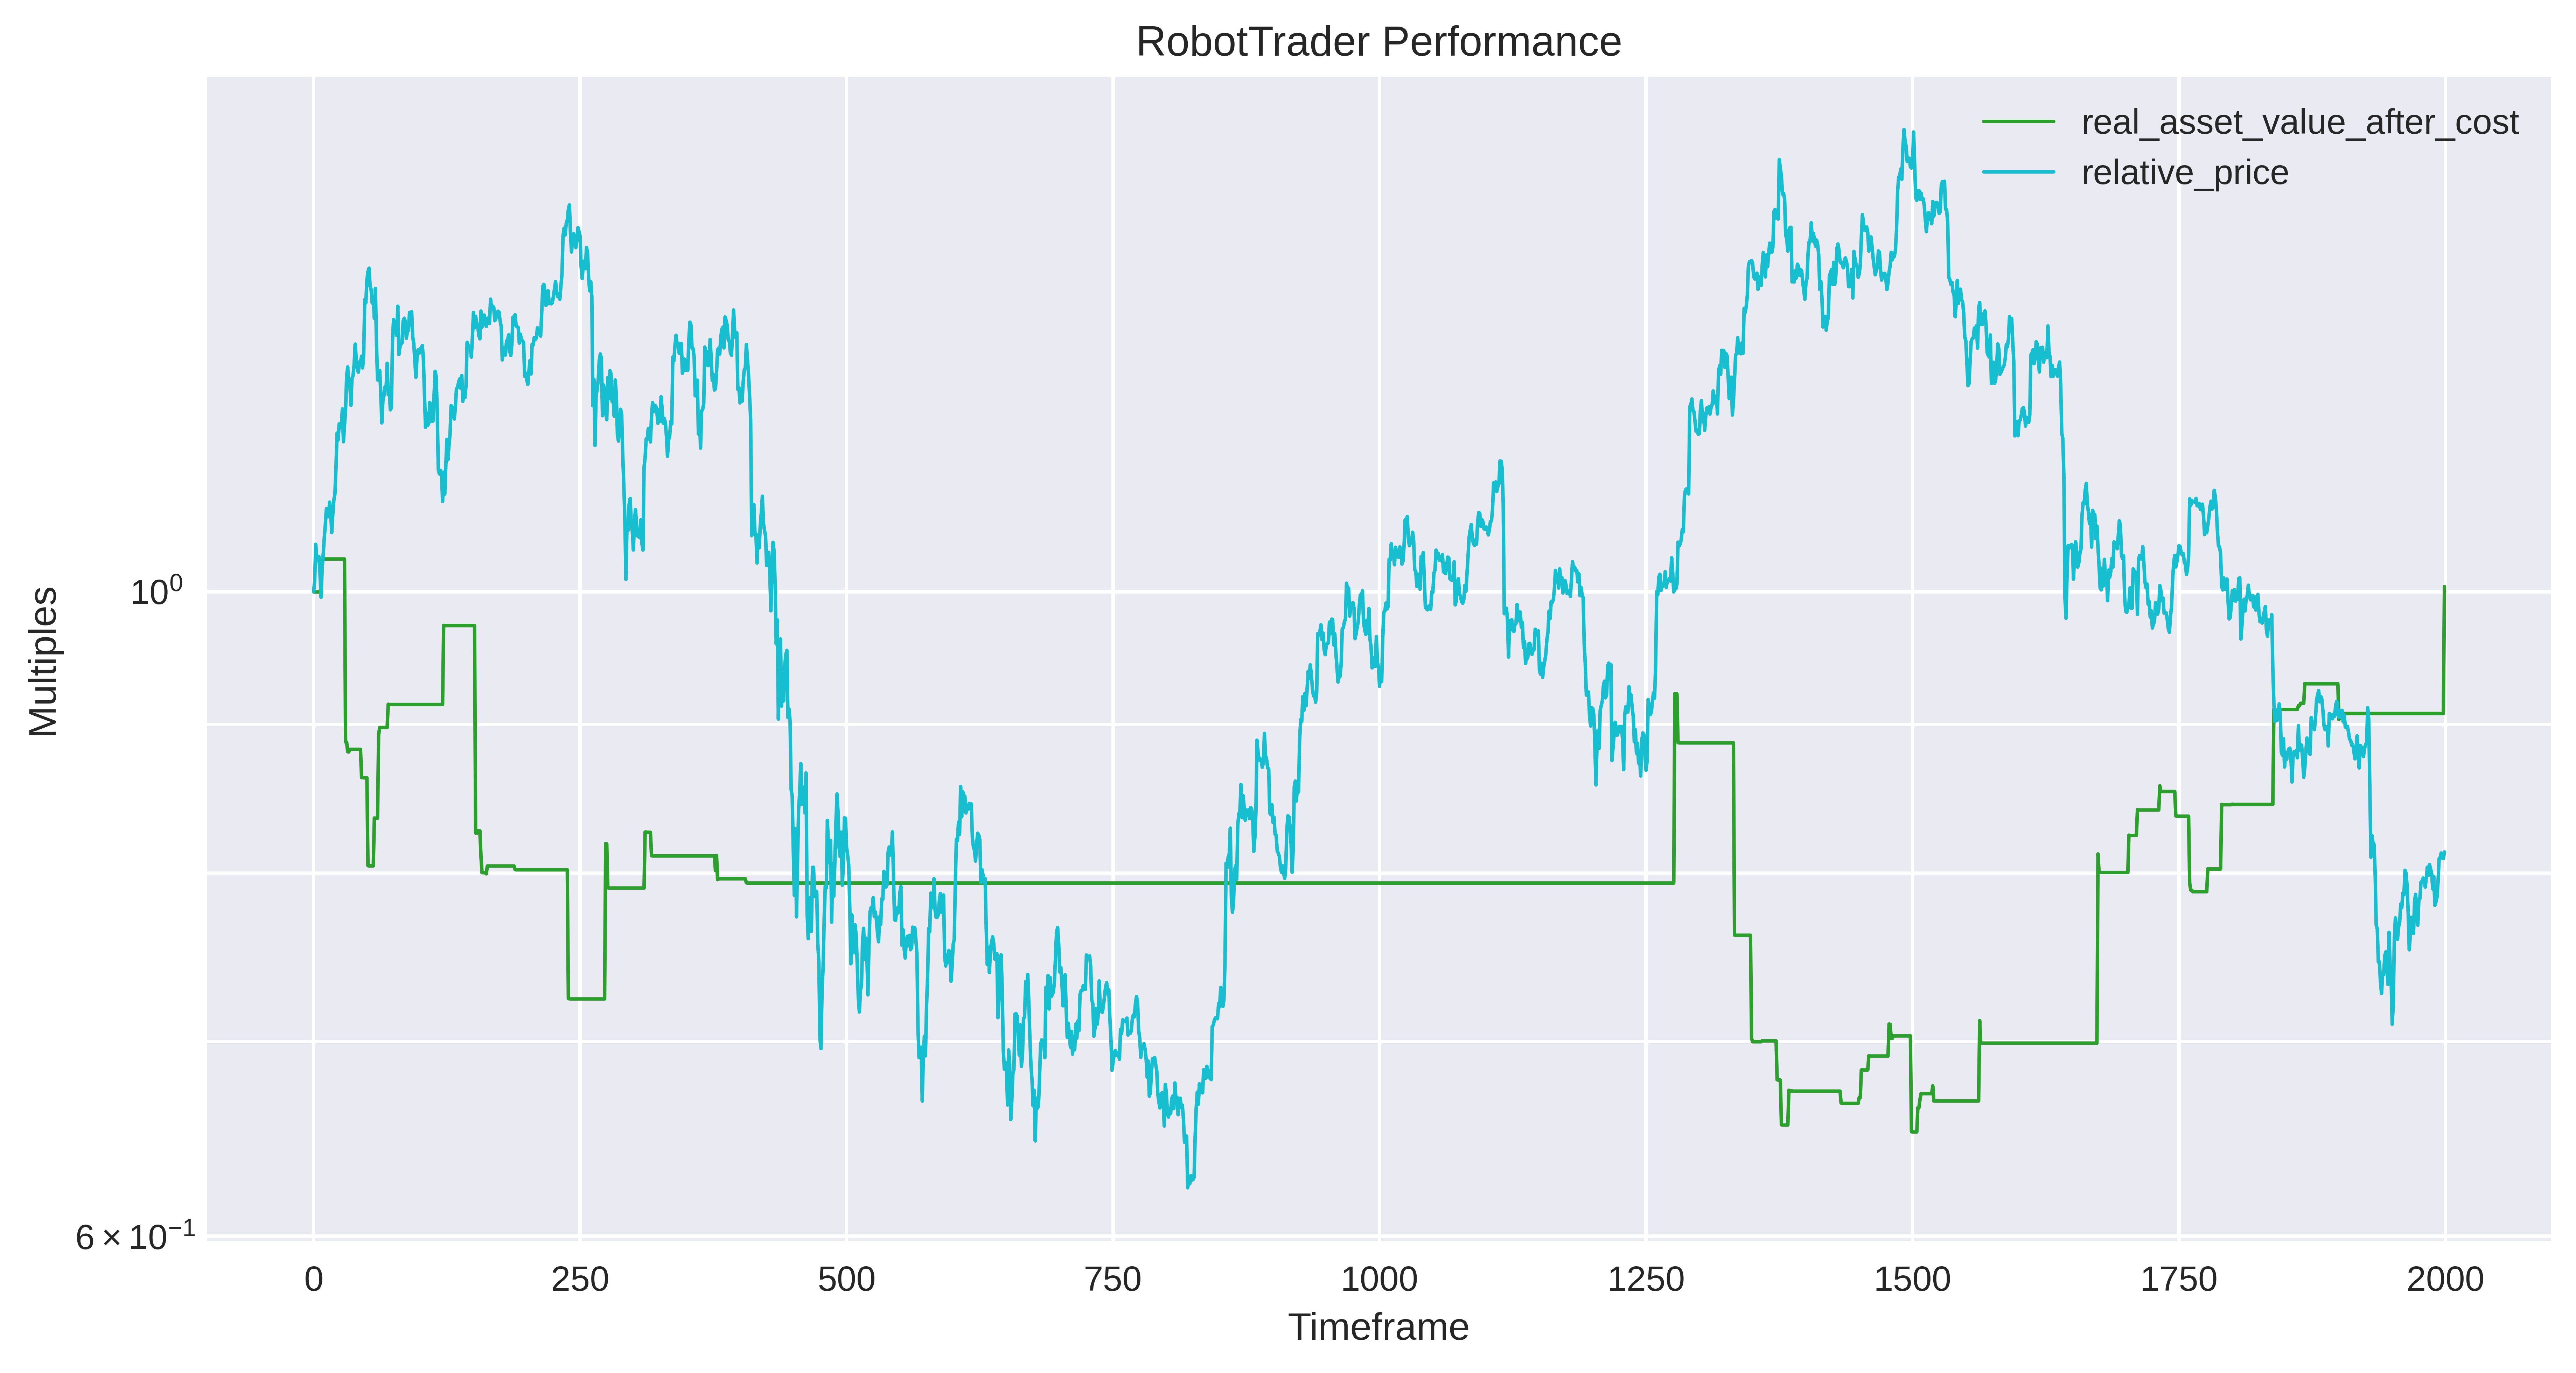

In [149]:
agent.predict(model=selected_model,environment=test_env,render = True,deterministic=False)